#Build the same using Tensorflow various variants low level, api, functional, model, builtin 

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
     

#sample data

In [30]:
n_samples = 250
input_dimensions = 3
output_dimensions = 2

tf.random.set_seed(123)
X = tf.random.uniform((n_samples, input_dimensions), -1, 1)
print('Samples values of x:', X[:3])

weights_true = tf.constant([[5., -1., -2], [-1., 3, 2]], dtype=tf.float32)
bias_true = tf.constant([[1], [-1]], dtype=tf.float32)

y_true = tf.matmul(-6 * X ** 2, weights_true, transpose_b=True) + tf.matmul(X, weights_true, transpose_b=True) + tf.transpose(bias_true)

print('Samples values of y:', y_true[:3])
print(f'X: {X.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')
     

Samples values of x: tf.Tensor(
[[-0.7476938   0.14550257 -0.4013734 ]
 [ 0.09236717  0.44103146  0.5779066 ]
 [-0.3846376  -0.03657794  0.30755043]], shape=(3, 3), dtype=float32)
Samples values of y: tf.Tensor(
[[-16.79237      0.42144525]
 [  4.783806    -6.07114   ]
 [ -4.797018    -0.3814491 ]], shape=(3, 2), dtype=float32)
X: (250, 3), weights: (2, 3), bias: (2, 1), y: (250, 2)


#plot 3-D data with sklearn TSNE

In [31]:
def plot_3d(title, X, y, y_pred=None):
  X_tsne = TSNE(n_components = 2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tsne[:, 0], X_tsne[:, 1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
     ax.scatter(X_tsne[:, 0], X_tsne[:, 1], y_pred, label='y_pred', marker = '^')
  plt.legend()
  plt.show()
     

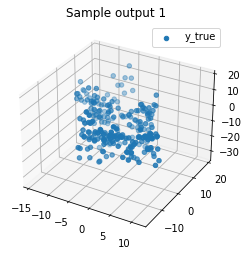

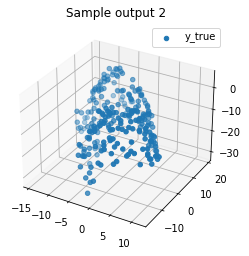

In [32]:
plot_3d('Sample output 1', X, y_true[:,0])
plot_3d('Sample output 2', X, y_true[:,1])

#Build Neural network

In [33]:
# Mean Squared Error

class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient

In [34]:
# Relu Activation layer

class Relu:
  def __init__(self):
    self.input = tf.constant([], dtype=tf.float32)

  def forward(self, input):
    self.input = input
    self.output = tf.clip_by_value(self.input, clip_value_min=0, clip_value_max=tf.float32.max)
    return self.output
  
  def backward(self, upstr_gradient):
    return tf.where((self.input > 0), upstr_gradient, 0)
  
  def update(self, lr):
    return

  def __str__(self):
    return 'ReLu'

In [35]:

class Layer:
  def __init__(self, n_input_nodes=1, n_output_nodes=1, activation_func=None):
    self.n_input_nodes = n_input_nodes
    self.n_output_nodes = n_output_nodes

    self.weights = tf.random.uniform((n_input_nodes, n_output_nodes), -1, 1)
    self.bias = tf.random.uniform((1, 1), -1, 1)
    self.X = tf.zeros([n_input_nodes])

    # Setting the activation function
    if activation_func == 'relu':
      self.activation_func = Relu()
    else: 
      self.activation_func = None
  
  def forward(self, X):
    self.X = X
    self.Z = tf.matmul(X, self.weights) + tf.transpose(self.bias)
    if self.activation_func == None:
      return self.Z 
    else:
      return self.activation_func.forward(self.Z)

  def backward(self, upstr_gradient):
    current_upstr_gradient = upstr_gradient

    if self.activation_func != None:
      current_upstr_gradient = self.activation_func.backward(current_upstr_gradient)
    
    self.dJdW = tf.matmul(self.X, current_upstr_gradient, transpose_a=True)
    self.dJdb = tf.reduce_sum(current_upstr_gradient, 1)
    self.dJdX = tf.matmul(current_upstr_gradient, self.weights, transpose_b=True)
    return self.dJdX

  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{} \nWeights:\n{} \nBias:{}'.format(self.n_input_nodes, self.n_output_nodes, self.activation_func, self.X[:2], 
            self.weights, self.bias)

In [36]:
class NeuralNetwork_Model:
  def __init__(self, n_inputs=3, n_hidden=[2], n_outputs=2, activation_func=None):
    self.n_inputs = n_inputs
    self.n_hidden = n_hidden
    self.n_outputs = n_outputs

    layers = [self.n_inputs] + self.n_hidden + [self.n_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation_func=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation_func))

    # Printing the network architecture
    print('Neural Network Architecture:')
    for i, layer in enumerate(self.layers):
      print('------------ Layer {} --------------'.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    current_output = inputs
    for l in self.layers:
      current_output = l.forward(current_output)
    return current_output
  
  def backward(self, y_pred, y_true):
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    print('MSE: ', mean_squared_error(y_true, y_pred))
    loss_gradient = mse.backward()

    gradient = loss_gradient
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  # Training loop over number of epochs
  def fit(self, X, y_true, epochs):
    for i in range(epochs):
      y_pred = self.forward(X)
      self.backward(y_pred, y_true)
      self.update(lr)

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

#Hyperparameters

In [37]:
# Number of Iterations
epochs = 200

# Learning rate of the algorithm
lr = 0.003

# Input and output size. i.e 3 and 2 relatively
input = X.shape[1]
output = y_true.shape[1]

print(input)
print(output)

3
2


#Training the Neural network with ReLU

In [38]:
model = NeuralNetwork_Model(n_inputs=input, n_hidden=[4, 3], n_outputs=output, activation_func='relu')
model.fit(X, y_true, epochs)
y_pred = model.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE with ReLU: {}'.format(err))

Neural Network Architecture:
------------ Layer 0 --------------
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0.] 
Weights:
[[ 0.7793751  -0.7529011   0.5437434   0.37014556]
 [ 0.28851962 -0.8450999   0.5011711   0.25016856]
 [-0.98454094  0.10740566  0.6778939  -0.12683797]] 
Bias:[[-0.02074623]]
------------ Layer 1 --------------
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0.] 
Weights:
[[-0.15719008  0.16138387 -0.43461084]
 [ 0.18330789  0.06609797  0.26230907]
 [-0.9721725  -0.9534869  -0.593735  ]
 [ 0.06146932  0.26102614  0.0592916 ]] 
Bias:[[0.9319067]]
------------ Layer 2 --------------
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[ 0.00907588  0.6003771 ]
 [-0.86684537  0.26448393]
 [-0.26869822 -0.833056  ]] 
Bias:[[0.98562145]]

MSE:  136.78528
MSE:  135.42377
MSE:  134.0725
MSE:  132.72365
MSE:  131.37485
MSE:  130.02164
MSE:  128.66116
MSE:  127.28601
MSE:  125.895096
MSE:  124.48572
MSE:  123.055145
MSE:  121.60202
MSE:  120.125496
M

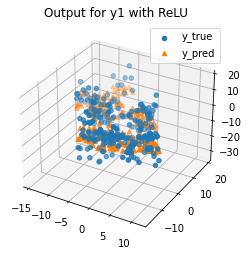

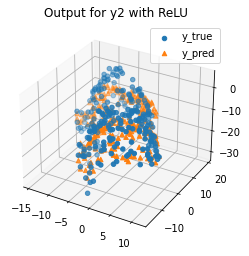

In [39]:
plot_3d('Output for y1 with ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2 with ReLU', X, y_true[:,1], y_pred[:,1])

#Train Neural network witout ReLU

In [40]:
model = NeuralNetwork_Model(n_inputs=input, n_hidden=[4, 3], n_outputs=output, activation_func=None)
model.fit(X, y_true, epochs)
y_pred = model.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE without ReLU: {}'.format(err))
     

Neural Network Architecture:
------------ Layer 0 --------------
Layer: (3,4) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[ 0.21406412 -0.8693714   0.18550944 -0.77581763]
 [-0.7346225  -0.09335279 -0.6945038   0.08219314]
 [ 0.48988867  0.26814365  0.0960238   0.17559028]] 
Bias:[[0.47292185]]
------------ Layer 1 --------------
Layer: (4,3) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[ 0.13541007  0.84781647  0.760139  ]
 [ 0.49782085 -0.20322347 -0.59163475]
 [-0.9811251   0.5657482   0.20415545]
 [ 0.65575075 -0.69732285  0.30343986]] 
Bias:[[-0.15410209]]
------------ Layer 2 --------------
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[-0.03670931  0.41420937]
 [-0.69833374 -0.06939197]
 [ 0.8501396  -0.4827993 ]] 
Bias:[[-0.8061199]]

MSE:  116.355255
MSE:  116.037834
MSE:  115.71622
MSE:  115.38841
MSE:  115.05258
MSE:  114.70674
MSE:  114.34926
MSE:  113.978355
MSE:  113.59235
MSE:  113.18971
MSE:  112.76892
MSE:  112.328445
MSE:  111.8670

the error is more when ReLU is not applied.

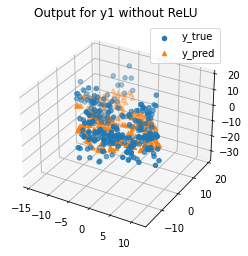

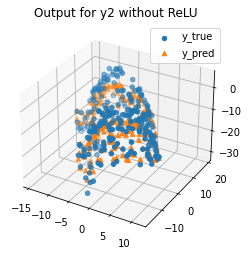

In [41]:
plot_3d('Output for y1 without ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2 without ReLU', X, y_true[:,1], y_pred[:,1])
     